# Génération de mélodies avec un RNN-LSTM - Partie 1 : preprocessing des données
ressource: tuto youtube *Melody generation with RNN-LSTM* de *Valerio Velardo*

In [102]:
import os
import music21 as m21
import json

### Préparation des données

Charger données

In [69]:
def load_songs(data_path, max_songs_nb):
    songs = []
    for path, subdirs, files in os.walk(data_path):
        for file in files:
            if file[-3:] == "krn":
                #print(os.path.join(path, file))
                song = m21.converter.parse(os.path.join(path, file))
                songs.append(song)
                max_songs_nb -= 1
                if max_songs_nb == 0 : return songs
    return songs

In [70]:
DATASET_PATH = "data/han"

print("loading data...")
songs = load_songs(DATASET_PATH, 100)
print("songs loaded")

loading data...
songs loaded


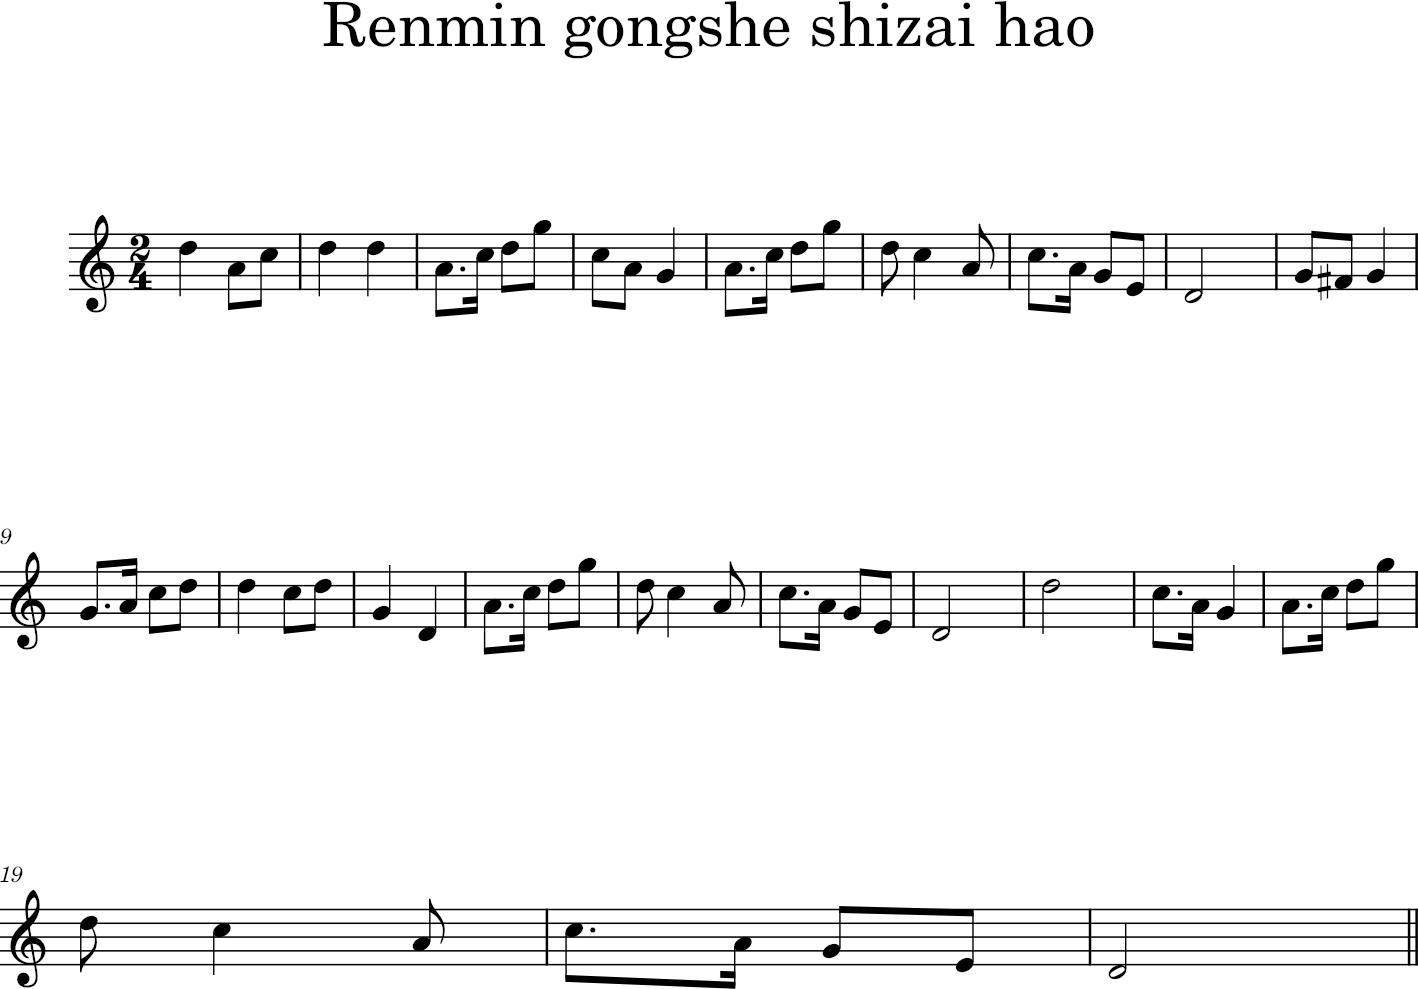

In [71]:
songs[0].show('midi')
songs[0].show()


Enlever les rythmes bizarres (garder les noires, croches, ...)

In [72]:
# durations are expressed in quarter length
ACCEPTABLE_DURATIONS = [
    0.25, # 16th note
    0.5, # 8th note
    0.75,
    1.0, # quarter note
    1.5,
    2, # half note
    3,
    4 # whole note
]

def has_acceptable_durations(song, acceptable_durations):
    for note in song.flatten().notesAndRests:
        if note.duration.quarterLength not in acceptable_durations:
            return False
    return True

In [73]:
print("avant filtrage :", len(songs))
for song in songs:
    if not has_acceptable_durations(song, ACCEPTABLE_DURATIONS):
        # song.show()
        # song.show("midi")
        songs.remove(song)
print("après filtrage :", len(songs))

avant filtrage : 100
après filtrage : 94


Transposer en do majeur/la mineur (= ne rien avoir à la clé, tout dans la même tonalité)

In [74]:
def transpose(song, print_enabled=False):
    # transpose song in Cmaj/Amin

    # get key signature
    parts = song.getElementsByClass(m21.stream.Part)
    measures_part0 = parts[0].getElementsByClass(m21.stream.Measure)
    key = measures_part0[0][4]
    if print_enabled : print("old key : ", key)

    # estimate key if not indicated
    if not isinstance(key, m21.key.Key):
        key = song.analyse("key")

    # get interval for transposition
    if key.mode == "major":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("C"))
    elif key.mode == "minor":
        interval = m21.interval.Interval(key.tonic, m21.pitch.Pitch("A"))
    
    transposed_song = song.transpose(interval)

    return transposed_song

Before transposition into Cmaj


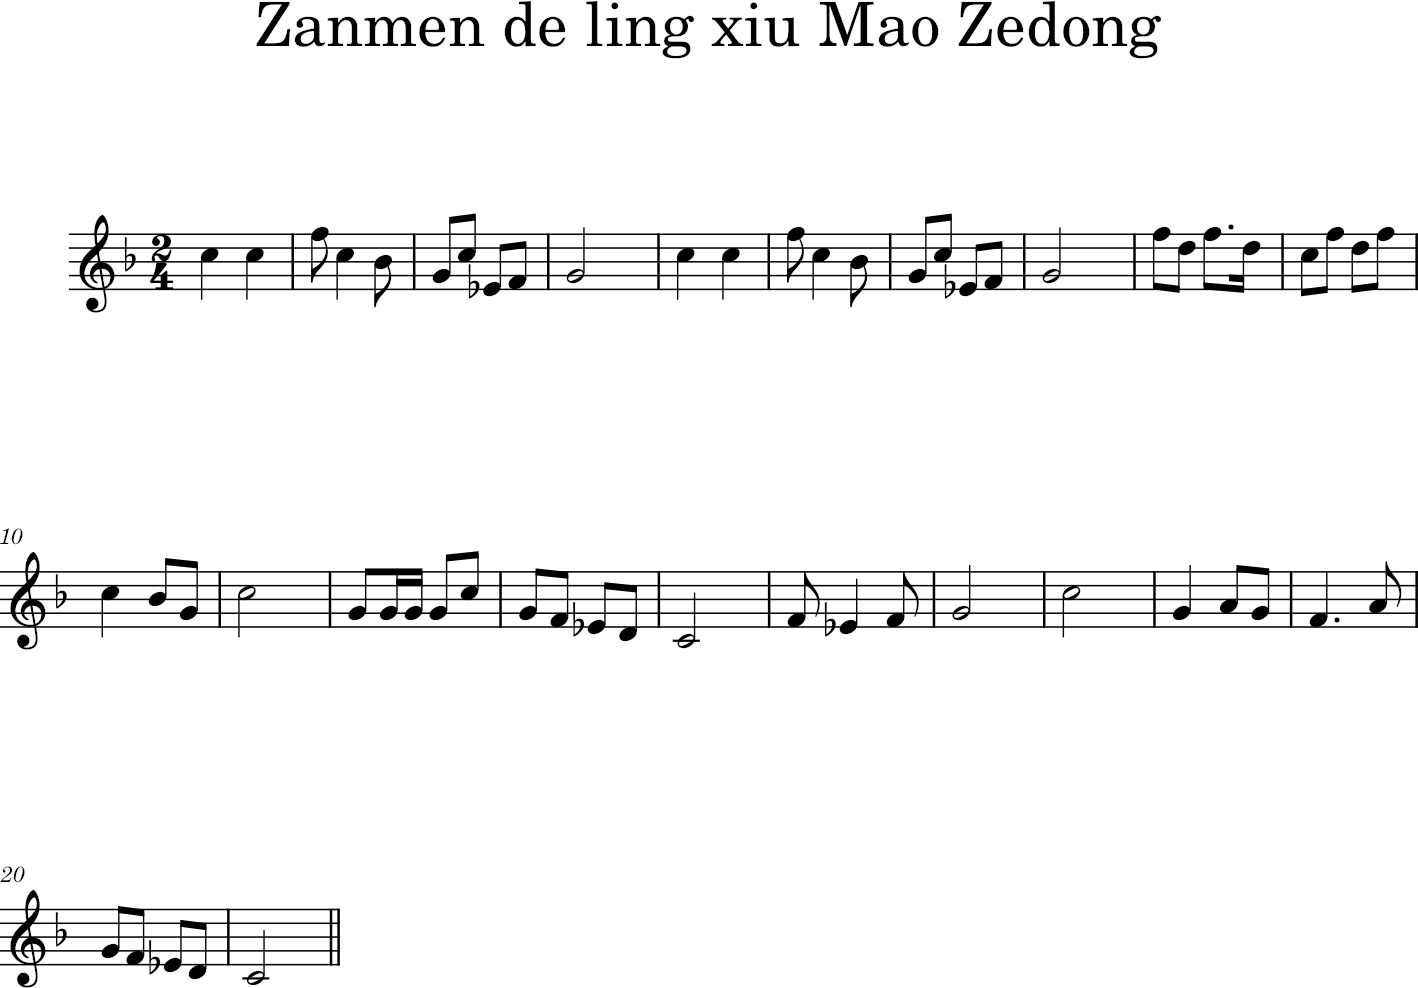

old key :  F major
After transposition into Cmaj


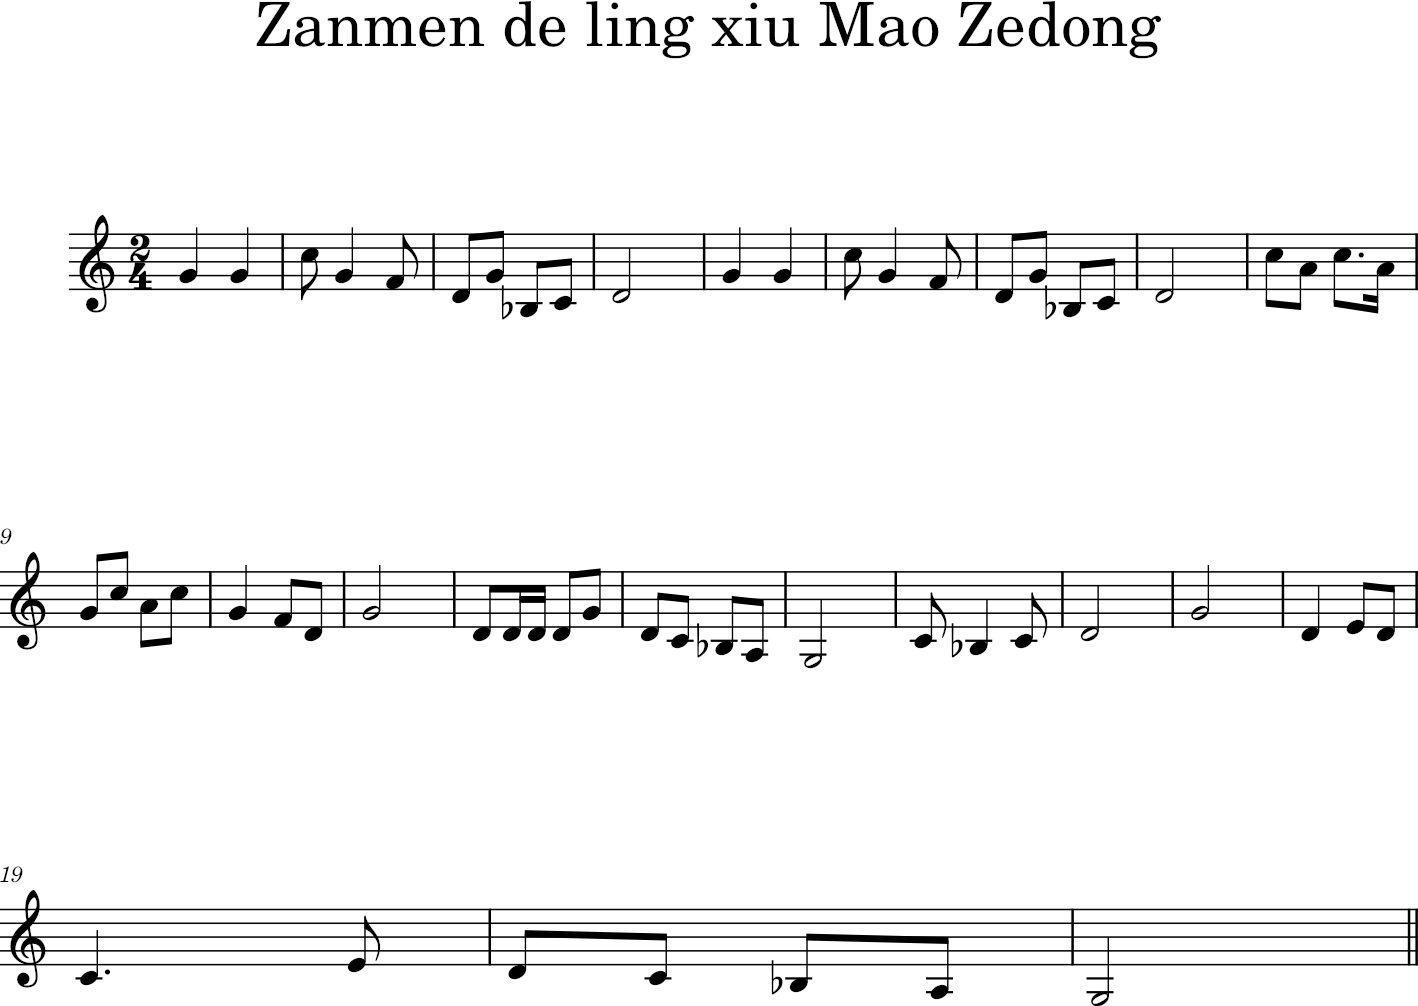

In [87]:
# test
song = songs[1]
print("Before transposition into Cmaj")
song.show('midi')
song.show()

song = transpose(song, True)
print("After transposition into Cmaj")
song.show('midi')
song.show()


In [78]:
transposed_songs = []
for song in songs:
    transposed_songs.append(transpose(song))

Encoder les musiques dans un format qui ira dans un fichier texte

In [82]:
def encode_song(song, time_step=0.25):
    """Converts a score into a time-series-like music representation. Each item in the encoded list represents 'min_duration'
    quarter lengths. The symbols used at each step are: integers for MIDI notes, 'r' for representing a rest, and '_'
    for representing notes/rests that are carried over into a new time step. Here's a sample encoding:

        ["r", "_", "60", "_", "_", "_", "72" "_"]

    :param song (m21 stream): Piece to encode
    :param time_step (float): Duration of each time step in quarter length
    :return:
    """

    encoded_song = []

    for event in song.flatten().notesAndRests:

        # handle notes
        if isinstance(event, m21.note.Note):
            symbol = event.pitch.midi # 60
        # handle rests
        elif isinstance(event, m21.note.Rest):
            symbol = "r"

        # convert the note/rest into time series notation
        steps = int(event.duration.quarterLength / time_step)
        for step in range(steps):

            # if it's the first time we see a note/rest, let's encode it. Otherwise, it means we're carrying the same
            # symbol in a new time step
            if step == 0:
                encoded_song.append(symbol)
            else:
                encoded_song.append("_")

    # cast encoded song to str
    encoded_song = " ".join(map(str, encoded_song))

    return encoded_song

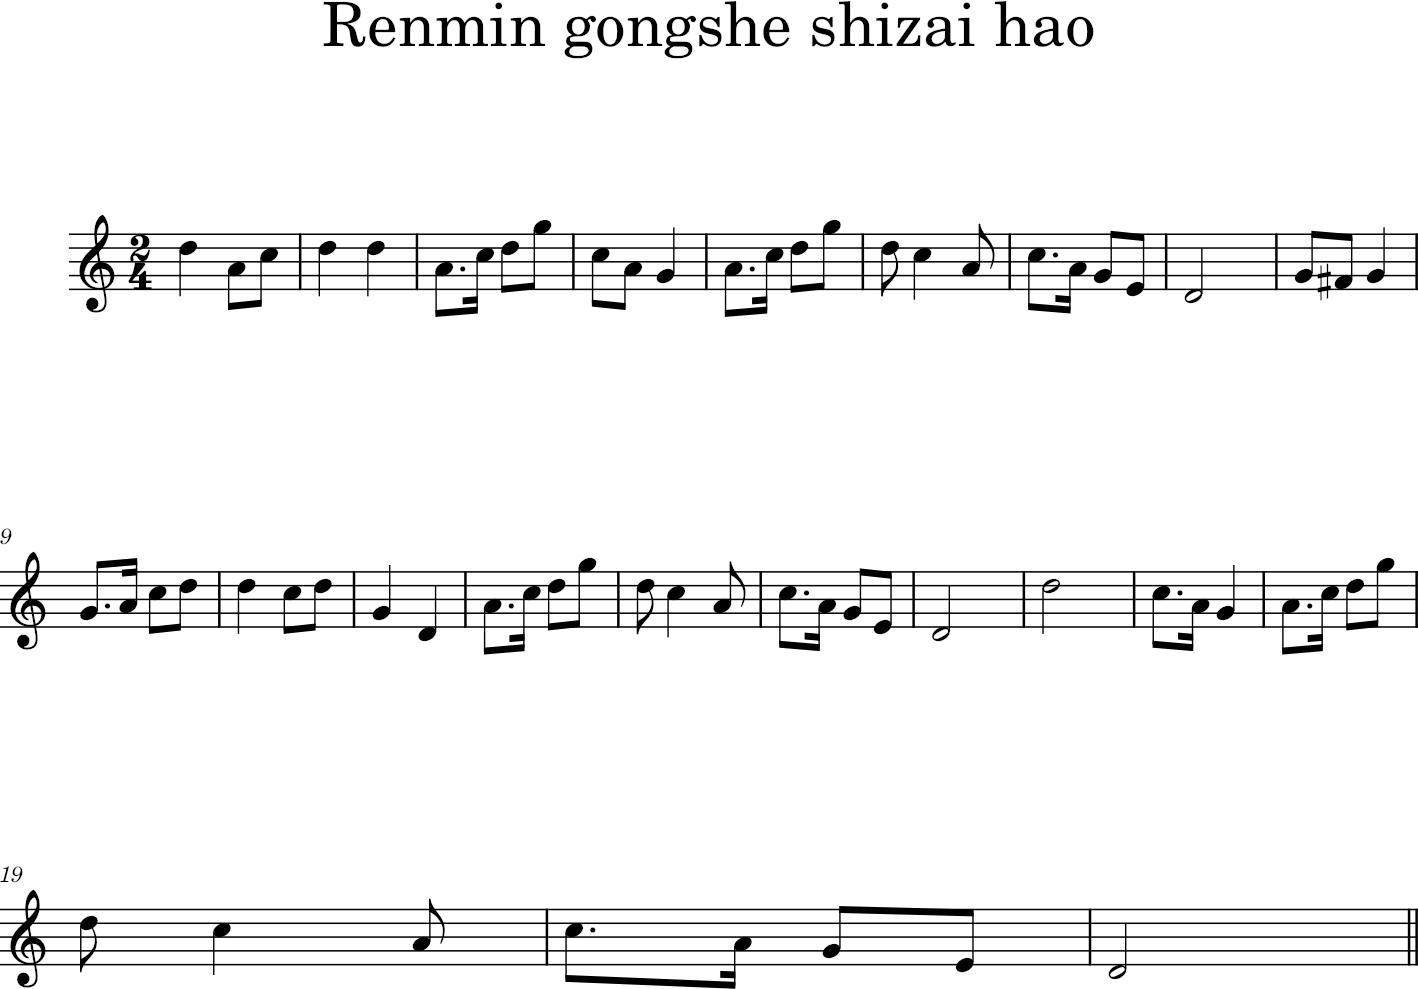

None
74 _ _ _ 69 _ 72 _ 74 _ _ _ 74 _ _ _ 69 _ _ 72 74 _ 79 _ 72 _ 69 _ 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 67 _ 66 _ 67 _ _ _ 67 _ _ 69 72 _ 74 _ 74 _ _ _ 72 _ 74 _ 67 _ _ _ 62 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 72 _ _ 69 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _


In [85]:
print(transposed_songs[0].show())
print(encode_song(transposed_songs[0]))

In [86]:
encoded_songs = []
for song in transposed_songs:
    encoded_songs.append(encode_song(song))

sauvegarde dans un fichier texte

In [89]:
SAVE_DIR = "data/han/encoded_songs"
for i, encoded_song in enumerate(encoded_songs):
    save_path = os.path.join(SAVE_DIR, str(i))
    with open(save_path, "w") as fp:
        fp.write(encoded_song)

In [97]:
#test
with open("data/han/encoded_songs/0", "r") as fp:
    song = fp.read()
    print(song)

74 _ _ _ 69 _ 72 _ 74 _ _ _ 74 _ _ _ 69 _ _ 72 74 _ 79 _ 72 _ 69 _ 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 67 _ 66 _ 67 _ _ _ 67 _ _ 69 72 _ 74 _ 74 _ _ _ 72 _ 74 _ 67 _ _ _ 62 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 72 _ _ 69 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _


tout mettre dans un fichier

In [98]:
def load(file_path):
    with open(file_path, "r") as fp:
        song = fp.read()
    return song

In [99]:
def create_single_file_dataset(dataset_path, file_dataset_path, sequence_length):
    """Generates a file collating all the encoded songs and adding new piece delimiters.

    :param dataset_path (str): Path to folder containing the encoded songs
    :param file_dataset_path (str): Path to file for saving songs in single file
    :param sequence_length (int): # of time steps to be considered for training
    :return songs (str): String containing all songs in dataset + delimiters
    """

    new_song_delimiter = "/ " * sequence_length
    songs = ""

    # load encoded songs and add delimiters
    for path, _, files in os.walk(dataset_path):
        for file in files:
            file_path = os.path.join(path, file)
            song = load(file_path)
            songs = songs + song + " " + new_song_delimiter

    # remove empty space from last character of string
    songs = songs[:-1]

    # save string that contains all the dataset
    with open(file_dataset_path, "w") as fp:
        fp.write(songs)

    return songs

In [100]:
create_single_file_dataset(dataset_path=SAVE_DIR, file_dataset_path="data/han/file_dataset", sequence_length=64)

'74 _ _ _ 69 _ 72 _ 74 _ _ _ 74 _ _ _ 69 _ _ 72 74 _ 79 _ 72 _ 69 _ 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 67 _ 66 _ 67 _ _ _ 67 _ _ 69 72 _ 74 _ 74 _ _ _ 72 _ 74 _ 67 _ _ _ 62 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ 74 _ _ _ _ _ _ _ 72 _ _ 69 67 _ _ _ 69 _ _ 72 74 _ 79 _ 74 _ 72 _ _ _ 69 _ 72 _ _ 69 67 _ 64 _ 62 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / / 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ 67 _ _ _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ 58 _ 60 _ 62 _ _ _ _ _ _ _ 72 _ 69 _ 72 _ _ 69 67 _ 72 _ 69 _ 72 _ 67 _ _ _ 65 _ 62 _ 67 _ _ _ _ _ _ _ 62 _ 62 62 62 _ 67 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ 60 _ 58 _ _ _ 60 _ 62 _ _ _ _ _ _ _ 67 _ _ _ _ _ _ _ 62 _ _ _ 64 _ 62 _ 60 _ _ _ _ _ 64 _ 62 _ 60 _ 58 _ 57 _ 55 _ _ _ _ _ _ _ / / / / / / / / / / / / / / / / / / / / / / / 

mapping dans un fichier json

In [101]:
def create_mapping(songs, mapping_path):
    """Creates a json file that maps the symbols in the song dataset onto integers

    :param songs (str): String with all songs
    :param mapping_path (str): Path where to save mapping
    :return:
    """
    mappings = {}

    # identify the vocabulary
    songs = songs.split()
    vocabulary = list(set(songs))

    # create mappings
    for i, symbol in enumerate(vocabulary):
        mappings[symbol] = i

    # save voabulary to a json file
    with open(mapping_path, "w") as fp:
        json.dump(mappings, fp, indent=4)


In [104]:
songs=load("data/han/file_dataset")
create_mapping(songs, "data/han/mapping.json")